# Python Text Analysis: Bag of Words

* * * 

<div class="alert alert-success">  
    
### Learning Objectives 
    
* Learn how to convert text data into numbers through a Bag-of-Words approach.
* Understand the TF-IDF algorithm and how it complements the Bag-of-Words representation.
* Implement Bag-of-Words and TF-IDF using the `sklearn` package and understand its parameter settings.
* Use the numerical representations of text data to perform sentiment analysis.
</div>

### Icons Used in This Notebook
🔔 **Question**: A quick question to help you understand what's going on.<br>
🥊 **Challenge**: Interactive excersise. We'll work through these in the workshop!<br>
🎬 **Demo**: Showing off something more advanced – so you know what Python can be used for!<br> 

### Sections
1. [Exploratory Data Analysis](#section1)
2. [Preprocessing](#section2)
3. [The Bag-of-Words Representation](#section3)
4. [Term Frequency-Inverse Document Frequency](#section4)
5. [Sentiment Classification Using the TF-IDF Representation](#section5)

In the previous part, we learned how to perform text preprocessing. However, we didn't move beyond the text data itself. If we're interested in doing any computational analysis on the text data, we still need approaches to convert the text into a **numeric representation**.

In Part 2 of our workshop series, we'll explore one of the most straightforward ways to generate a numeric representation from text: the **bag-of-words** (BoW). We will implement the BoW representation to transform our airline tweets data, and then build a classifier to explore what it tells us about the sentiment of the tweets. At the heart of the bag-of-words approach lies the assumption that the frequency of specific tokens is informative about the semantics and sentiment underlying the text.

We'll make heavy use of the `scikit-learn` package to do so, as it provides a nice framework for constructing the numeric representation.

Let's install `scikit-learn` firstǃ

In [68]:
# Uncomment to install the package
# %pip install scikit-learn

In [69]:
# Uncomment to install the NLP packages introduced in Part 1
# %pip install NLTK
# %pip install spaCy
# !python -m spacy download en_core_web_sm

In [70]:
# Import other packages
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
%matplotlib inline

<a id='section1'></a>

# Exploratory Data Analysis

Before we ever do any preprocessing or modeling, we always should perform exploratory data analysis to familiarize ourselves with the data.

In [71]:
# Read in data
tweets_path = '../data/airline_tweets.csv'
tweets = pd.read_csv(tweets_path, sep=',')

In [72]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


As a refresher, each row in this dataframe correponds to a tweet. The following columns are of main interests to us. There are other columns containing metadata of the tweet, such as the author of the tweet, when it was created, the timezone of the user, and others, which we will set aside for now. 

- `text` (`str`): the text of the tweet.
- `airline_sentiment` (`str`): the sentiment of the tweet, labeled as "neutral," "positive," or "negative." 
- `airline` (`str`): the airline that is tweeted about.
- `retweet count` (`int`): how many times the tweet was retweeted.

To prepare us for sentiment classification, we'll partition the dataset to focus on the "positive" and "negative" tweets for now. 

In [73]:
tweets = tweets[tweets['airline_sentiment'] != 'neutral'].reset_index(drop=True)

Let's take a look at a few tweets first!

In [74]:
# Print first five tweets
for idx in range(5):
    print(tweets['text'].iloc[idx])

@VirginAmerica plus you've added commercials to the experience... tacky.
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
@VirginAmerica and it's a really big bad thing about it
@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)


We can already see that some of these tweets contain negative sentiment—how can we tell this is the case? 

Next, let's take a look at the distribution of sentiment labels in this dataset. 

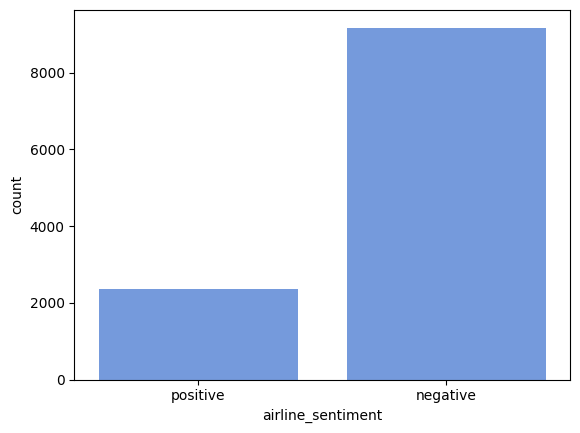

In [75]:
# Make a bar plot showing the count of tweet sentiments
sns.countplot(data=tweets,
              x='airline_sentiment', 
              color='cornflowerblue',
              order=['positive', 'negative']);

It looks like the majority of the tweets in this dataset are expressing negative sentiment!

Let's take a look at what gets more retweeted:

In [76]:
# Get the mean retweet count for each sentiment
tweets.groupby('airline_sentiment')['retweet_count'].mean()

airline_sentiment
negative    0.093375
positive    0.069403
Name: retweet_count, dtype: float64

Negative tweets are clearly retweeted more often than positive ones!

Let's see which airline receives most negative tweets:

In [77]:
# Get the proportion of negative tweets by airline
proportions = tweets.groupby(['airline', 'airline_sentiment']).size() / tweets.groupby('airline').size()
proportions.unstack().sort_values('negative', ascending=False)

airline_sentiment,negative,positive
airline,,
US Airways,0.893760,0.106240
American,0.853659,0.146341
United,0.842560,0.157440
Southwest,0.675399,0.324601
Delta,0.637091,0.362909
Virgin America,0.543544,0.456456


It looks like people are most dissatified with US Airways, followed by American Airline, both having over 85\% negative tweets!

A lot of interesting discoveries could be made if you want to explore more about the data. Now let's return to our task of sentiment analysis. Before that, we need to preprocess the text data so that they are in a standard format.

<a id='section2'></a>
# Preprocessing

We spent much of Part 1 learning how to preprocess data. Let's apply what we learned! Looking at some of the tweets above, we can see that while they are in pretty good shape, we can do some additional processing on them.

In our pipeline, we'll omit the tokenization process since we will perform it in a later step. 

## 🥊 Challenge 1: Apply a Text Cleaning Pipeline

Write a function called `preprocess` that performs the following steps on a text input:

* Step 1: Lowercase the text input.
* Step 2: Replace the following patterns with placeholders:
    * URLs &rarr; ` URL `
    * Digits &rarr; ` DIGIT `
    * Hashtags &rarr; ` HASHTAG `
    * Tweet handles &rarr; ` USER `
* Step 3: Remove extra blankspace.

Here are some hints to guide you through this challenge:

* For Step 1, recall from Part 1 that a string method called [`.lower()`](https://docs.python.org/3.11/library/stdtypes.html#str.lower) can be usd to convert text to lowercase. 
* We have integrated Step 2 into a function called `placeholder`. Run the cell below to import it into your notebook, and you can use it just like any other functions.
* For Step 3, we have provided the regex pattern for identifying whitespace characters as well as the correct replacement for extract whitespace. 

Run your `preprocess` function on `example_tweet` (three cells below) to check if it works. If it does, apply it to the entire `text` column in the tweets dataframe.

In [78]:
from utils import placeholder
import re

In [79]:
blankspace_pattern = r'\s+'
blankspace_repl = ' '

def preprocess(text):
    '''Create a preprocess pipeline that cleans the tweet data.'''
    
    # Step 1: Convert text to lowercase
    text = text.lower()
    
    # Step 2: Replace patterns with placeholders (URLs, digits, hashtags, user handles)
    text = placeholder(text)
    
    # Step 3: Remove extra whitespace characters
    text = re.sub(blankspace_pattern, blankspace_repl, text)
    
    return text

In [80]:
example_tweet = 'lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo'

# Print the example tweet
print(example_tweet)
print(f"{'='*50}")

# Print the preprocessed tweet
print(preprocess(example_tweet))

lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo
lol USER and USER are like soo DIGIT HASHTAG HASHTAG saw it on URL HASHTAG 


In [81]:
# Apply the function to the text column and assign the preprocessed tweets to a new column
tweets['text_processed'] = tweets['text'].apply(lambda x: preprocess(x))
tweets['text_processed'].head()

0     USER plus you've added commercials to the exp...
1     USER it's really aggressive to blast obnoxiou...
2        USER and it's a really big bad thing about it
3     USER seriously would pay $ DIGIT a flight for...
4     USER yes, nearly every time i fly vx this “ea...
Name: text_processed, dtype: object

Congratualtions! Preprocessing is done. Let's dive into the bag-of-words!

<a id='section3'></a>
# La Representación Bag-of-Words

La idea de bag-of-words (BoW), como sugiere el nombre, es bastante intuitiva: tomamos un documento y lo arrojamos en una bolsa. La acción de "arrojar" el documento en una bolsa ignora la posición relativa entre las palabras, por lo que lo que queda "en la bolsa" es esencialmente "un conjunto desordenado de palabras" [(Jurafsky & Martin, 2024)](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf). A cambio, obtenemos una lista de palabras únicas y la frecuencia de cada una de ellas. 

Por ejemplo, como se muestra en la siguiente ilustración, la palabra "coffee" aparece dos veces. 

<img src='../images/bow-illustration-1.png' alt="BoW-Part2" width="600">

Con una representación bag-of-words, hacemos un uso intensivo de la frecuencia de las palabras, pero no tanto del orden en que aparecen. 

En el contexto del análisis de sentimiento, el sentimiento de un tweet se transmite más fuertemente a través de palabras específicas. Por ejemplo, si un tweet contiene la palabra "happy", es probable que transmita un sentimiento positivo, aunque no siempre (por ejemplo, "not happy" denota el sentimiento opuesto). Cuando estas palabras aparecen con mayor frecuencia, probablemente transmitirán el sentimiento con más fuerza.


## Document Term Matrix

Ahora implementemos la idea de bag-of-words. Antes de profundizar, retrocedamos un momento. En la práctica, el análisis de texto a menudo implica manejar múltiples documentos; de ahora en adelante, utilizaremos el término **document** para representar un fragmento de texto sobre el cual realizamos análisis. Puede ser una frase, una oración, un tweet o cualquier otro texto—mientras pueda representarse como una cadena de caracteres, su longitud no es realmente un problema.  

Imagina que tenemos cuatro documentos (es decir, las cuatro frases mostradas anteriormente) y los arrojamos todos en la bolsa. En lugar de obtener una lista de frecuencias de palabras, obtendremos una document-term matrix (DTM). En una DTM, la lista de palabras constituye el **vocabulary** (V), que contiene todas las palabras únicas que aparecen en los documentos. Para cada **document** (D), contamos la cantidad de veces que aparece cada palabra en el vocabulario y luego colocamos ese número en la matriz. En otras palabras, la DTM que construiremos es una matriz $D \times V$, donde cada fila corresponde a un documento y cada columna a un token (o "término").  

Los tokens únicos en este conjunto de documentos, organizados en orden alfabético, forman las columnas. Para cada documento, marcamos la frecuencia de cada palabra presente en el documento. La representación numérica de cada documento es una fila en la matriz. Por ejemplo, el primer documento, "the coffee roaster", tiene la representación numérica $[0, 1, 0, 0, 0, 1, 1, 0]$.  

Nota que la columna de índices a la izquierda muestra estos documentos como texto, pero típicamente solo se les asignaría un número de índice.  

$$
\begin{array}{c|cccccccccccc}
 & \text{americano} & \text{coffee} & \text{iced} & \text{light} & \text{roast} & \text{roaster} & \text{the} & \text{time} \\\hline
\text{the coffee roaster} &0 &1	&0	&0	&0	&1	&1	&0 \\ 
\text{light roast} &0 &0	&0	&1	&1	&0	&0	&0 \\
\text{iced americano} &1 &0	&1	&0	&0	&0	&0	&0 \\
\text{coffee time} &0 &1	&0	&0	&0	&0	&0	&1 \\
\end{array}
$$

Para crear una DTM, utilizaremos `CountVectorizer` del paquete `sklearn`.


In [82]:
from sklearn.feature_extraction.text import CountVectorizer

La siguiente ilustración muestra el flujo de trabajo en tres pasos para crear una DTM con `CountVectorizer`.

<img src='../images/CountVectorizer1.png' alt="CountVectorizer" width="500">

Repasemos estos pasos utilizando el ejemplo simple mostrado anteriormente.

### Un Ejemplo Sencillo


In [83]:
# A toy example containing four documents
test = ['the coffee roaster',
        'light roast',
        'iced americano',
        'coffee time']

El primer paso es inicializar un objeto `CountVectorizer`. Dentro de los paréntesis, podemos especificar parámetros de configuración si lo deseamos. Echemos un vistazo a la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) para ver qué opciones están disponibles.  

Por ahora, podemos dejarlo en blanco para usar la configuración predeterminada.  

In [84]:
# Create a CountVectorizer object
vectorizer = CountVectorizer()

El segundo paso es aplicar `fit` al objeto `CountVectorizer` con los datos, lo que significa crear un vocabulario de tokens a partir del conjunto de documentos. Luego, en el tercer paso, usamos `transform` para procesar nuestros datos de acuerdo con el objeto `CountVectorizer` "ajustado". Esto implica tomar cada documento y contar la aparición de tokens según el vocabulario establecido durante el paso de "ajuste".  

Puede sonar un poco complejo, pero los pasos 2 y 3 pueden realizarse en una sola operación utilizando la función `fit_transform`.  

In [85]:
# Fit and transform to create a DTM
test_count = vectorizer.fit_transform(test)

El resultado de `fit_transform` debería ser la DTM.  

¡Echemos un vistazo!  

In [86]:
test_count

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 9 stored elements and shape (4, 8)>

Aparentemente, hemos obtenido una "sparse matrix", es decir, una matriz que contiene muchos ceros. Esto tiene sentido: en cada documento, hay palabras que no aparecen en absoluto, y estas se registran como ceros en la DTM. Esta matriz dispersa se almacena en un formato "Compressed Sparse Row", un formato optimizado para ahorrar memoria al manejar matrices dispersas.  

Convirtámosla en una matriz densa, donde esos ceros probablemente estén representados, como en un array de numpy.  

In [87]:
# Convert DTM to a dense matrix 
test_count.todense()

matrix([[0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1]])

¡Así que esta es nuestra DTM! La matriz es la misma que mostramos anteriormente. Para hacerla más fácil de leer, convirtámosla en un dataframe. Los nombres de las columnas deben ser los tokens del vocabulario, a los cuales podemos acceder con la función `get_feature_names_out`.  

In [88]:
# Retrieve the vocabulary
vectorizer.get_feature_names_out()

array(['americano', 'coffee', 'iced', 'light', 'roast', 'roaster', 'the',
       'time'], dtype=object)

In [89]:
# Create a DTM dataframe
test_dtm = pd.DataFrame(data=test_count.todense(),
                        columns=vectorizer.get_feature_names_out())

¡Aquí está! La DTM de nuestros datos de ejemplo ahora es un dataframe. El índice de `test_dtm` corresponde a la posición de cada documento en la lista `test`.  

In [90]:
test_dtm

,americano,coffee,iced,light,roast,roaster,the,time
0,0,1,0,0,0,1,1,0
1,0,0,0,1,1,0,0,0
2,1,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,1


Esperamos que este ejemplo sencillo haya proporcionado una guía clara para crear una DTM.

¡Ahora es el momento de trabajar con nuestros datos de tweets!

### DTM para Tweets

Comenzaremos inicializando un objeto `CountVectorizer`. En la siguiente celda, hemos incluido algunos parámetros que las personas ajustan con frecuencia. Estos parámetros están configurados actualmente con sus valores predeterminados.

Cuando construimos una DTM, el valor predeterminado es convertir a minúsculas el texto de entrada. Si no se proporciona nada para `stop_words`, el valor predeterminado es mantenerlas. Los siguientes tres parámetros se usan para controlar el tamaño del vocabulario, sobre lo cual volveremos en un momento.

In [91]:
# Create a CountVectorizer object
vectorizer = CountVectorizer(lowercase=True,
                             stop_words=None,
                             min_df=1,
                             max_df=1.0, 
                             max_features=None)

In [92]:
# Fit and transform to create DTM
counts = vectorizer.fit_transform(tweets['text_processed'])
counts

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 191139 stored elements and shape (11541, 8751)>

In [93]:
# Do not run if you have limited memory - this includes DataHub and Binder
np.array(counts.todense())

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(11541, 8751))

In [94]:
# Extract tokens
tokens = vectorizer.get_feature_names_out()

In [95]:
# Create DTM
first_dtm = pd.DataFrame(data=counts.todense(),
                         index=tweets.index,
                         columns=tokens)

# Print the shape of DTM
print(first_dtm.shape)

(11541, 8751)


Si dejamos el `CountVectorizer` con la configuración predeterminada, el tamaño del vocabulario de los datos de los tweets es 8751.  

In [96]:
first_dtm.head()

,_exact_,_wtvd,aa,aaaand,aadv,aadvantage,aal,aaron,ab,aback,...,zero,zig,zip,zippers,zone,zones,zoom,zukes,zurich,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


La mayoría de los tokens tienen cero ocurrencias, al menos en los primeros cinco tweets.  

¡Echemos un vistazo más de cerca a la DTM!  

In [97]:
# Most frequent tokens
first_dtm.sum().sort_values(ascending=False).head(10)

user      12882
to         6987
digit      6927
the        5088
you        3635
for        3386
flight     3320
and        3276
on         3142
my         2751
dtype: int64

In [98]:
# Least frequent tokens
first_dtm.sum().sort_values(ascending=True).head(10)

zones         1
accelerate    1
acc           1
acarl         1
yogurt        1
yoga          1
yikes         1
absurdity     1
absorber      1
absorb        1
dtype: int64

No es sorprendente ver que "user" y "digit" estén entre los tokens más frecuentes, ya que reemplazamos cada uno de los idiosincráticos con estos marcadores de posición. El resto de los tokens más frecuentes son principalmente palabras vacías (stop words).

Tal vez un patrón más interesante sea buscar qué token aparece más en cualquier tweet dado:

In [99]:
counts = pd.DataFrame()

# Retrieve the index of the tweet where a token appears most frequently
counts['token'] = first_dtm.idxmax(axis=1)

# Retrieve the number of occurrence 
counts['number'] = first_dtm.max(axis=1)

# Filter out placeholders
counts[(counts['token']!='digit')
       & (counts['token']!='hashtag')
       & (counts['token']!='user')].sort_values('number', ascending=False).head(10)

,token,number
3127,lt,6
918,worst,6
11007,to,5
5513,to,5
7750,to,5
10923,the,5
4089,to,5
8134,to,5
8148,the,5
557,to,5


Parece que, entre todos los tweets, como máximo un token aparece seis veces, y es ya sea la palabra "It" o la palabra "worst."

Volvamos a nuestro dataframe de tweets y ubiquemos el tweet número 918.

In [100]:
# Retrieve 918th tweet: "worst"
tweets.iloc[918]['text']

"@united is the worst. Worst reservation policies. Worst costumer service. Worst worst worst. Congrats, @Delta you're not that bad!"

## Personalizar el `CountVectorizer`

Hasta ahora, siempre hemos utilizado la configuración predeterminada de parámetros para crear nuestras DTMs, pero en muchos casos, es posible que queramos personalizar el objeto `CountVectorizer`. El propósito de hacerlo es filtrar más a fondo los tokens innecesarios. En el ejemplo siguiente, ajustamos los siguientes parámetros:

- `stop_words = 'english'`: ignorar las palabras vacías en inglés
- `min_df = 2`: ignorar palabras que no ocurren al menos dos veces
- `max_df = 0.95`: ignorar palabras que aparecen en más del 95\% de los documentos

🔔 **Pregunta**: ¡Paremos un minuto para discutir si tiene sentido establecer estos parámetros! ¿Qué opinas?

A menudo, no estamos interesados en palabras cuya frecuencia es demasiado baja o demasiado alta, por lo que usamos `min_df` y `max_df` para filtrarlas. Alternativamente, podemos definir el tamaño de nuestro vocabulario como $N$ configurando `max_features`. En otras palabras, le decimos a `CountVectorizer` que solo considere los $N$ tokens más frecuentes al construir la DTM.

In [101]:
# Customize the parameter setting
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

In [102]:
# Fit, transform, and get tokens
counts = vectorizer.fit_transform(tweets['text_processed'])
tokens = vectorizer.get_feature_names_out()

# Create the second DTM
second_dtm = pd.DataFrame(data=counts.todense(),
                          index=tweets.index,
                          columns=tokens)

Nuestra segunda DTM tiene un vocabulario considerablemente más pequeño en comparación con la primera.

In [103]:
print(first_dtm.shape)
print(second_dtm.shape)

(11541, 8751)
(11541, 4471)


In [104]:
second_dtm.head()

,aa,aadv,aadvantage,aal,abandoned,abc,ability,able,aboard,abq,...,yummy,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


La lista de tokens más frecuentes ahora incluye palabras que tienen más sentido para nosotros, como "cancelled" y "service."

In [105]:
second_dtm.sum().sort_values(ascending=False).head(10)

digit        6927
flight       3320
hashtag      2633
cancelled     956
thanks        921
service       910
just          801
customer      726
time          695
help          687
dtype: int64

## 🥊 Challenge 2: Lemmatize the Text Input

Recall from Part 1 that we introduced using `spaCy` to perform lemmatization, i.e., to "recover" the base form of a word. This process will reduce vocabulary size by keeping word variations minimal—a smaller vocabularly may help improve model performance in sentiment classification. 

Now let's implement lemmatization on our tweet data and use the lemmatized text to create a third DTM. 

Complete the function `lemmatize_text`. It requires a text input and returns the lemmas of all tokens. 

Here are some hints to guide you through this challenge:

- Step 1: initialize a list to hold lemmas
- Step 2: apply the `nlp` pipeline to the input text
- Step 3: iterate over tokens in the processed text and retrieve the lemma of the token
    - HINT: lemmatization is one of the linguistic annotations that the `nlp` pipeline automatically does for us. We can use `token.lemma_` to access the annotation.

In [106]:
# Import spaCy
import spacy
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Cargar el modelo de spaCy
nlp = spacy.load('en_core_web_sm')

In [107]:
# Create a function to lemmatize text
def lemmatize_text(text):
    '''Lemmatize the text input with spaCy annotations.'''
    
    # Step 1: Initialize an empty list to hold lemmas
    lemma = []
    
    # Step 2: Apply the nlp pipeline to input text
    doc = nlp(text)
    
    # Step 3: Iterate over tokens in the text to get the token lemma
    for token in doc:
        lemma.append(token.lemma_)
    
    # Step 4: Join lemmas together into a single string
    text_lemma = ' '.join(lemma)
    
    return text_lemma

Let's apply the function to the following example tweet first!

In [108]:
# Apply the function to an example tweet
print(tweets.iloc[33]["text_processed"])
print(f"{'='*50}")
print(lemmatize_text(tweets.iloc[33]['text_processed']))

 USER wow this just blew my mind
  USER wow this just blow my mind


And then let's lemmatize the tweet data and save the output to a new column `text_lemmatized`.

In [109]:
# This may take a while!
tweets['text_lemmatized'] = tweets['text_processed'].apply(lambda x: lemmatize_text(x))

Now with the `text_lemmatized` column, let's create a third DTM. The parameter setting is the same as the second DTM. 

In [110]:
# Create the vectorizer (the same param setting as previous)
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

# Fit, transform, and get tokens
counts = vectorizer.fit_transform(tweets['text_lemmatized'])
tokens = vectorizer.get_feature_names_out()

# Create the third DTM
third_dtm = pd.DataFrame(data=counts.todense(),
                         index=tweets.index,
                         columns=tokens)
third_dtm.head()

,aa,aadv,aadvantage,aal,abandon,abc,ability,able,aboard,abq,...,yummy,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
# Print the shapes of three DTMs
print(first_dtm.shape)
print(second_dtm.shape)
print(third_dtm.shape)

(11541, 8751)
(11541, 4471)
(11541, 3571)


Let's print the top 10 most frequent tokens as usual. These tokens are now lemmas and their counts also change after lemmatization. 

In [112]:
# Get the most frequent tokens in the third DTM
third_dtm.sum().sort_values(ascending=False).head(10)

digit       6927
flight      3952
hashtag     2633
thank       1454
hour        1134
cancel       951
service      939
delay        934
customer     902
time         860
dtype: int64

In [113]:
# Compared to the most frequent tokens in the second DTM
second_dtm.sum().sort_values(ascending=False).head(10)

digit        6927
flight       3320
hashtag      2633
cancelled     956
thanks        921
service       910
just          801
customer      726
time          695
help          687
dtype: int64

<a id='section4'></a>

# Term Frequency-Inverse Document Frequency 

So far, we're relying on word frequency to give us information about a document. This assumes if a word appears more often in a document, it's more informative. However, this may not always be the case. For example, we've already removed stop words because they are not informative, despite the fact that they appear many times in a document. We also know the word "flight" is among the most frequent words, but it is not that informative, because it appears in many documents. Since we're looking at airline tweets, we shouldn't be surprised to see the word "flight"!

To remedy this, we use a weighting scheme called **tf-idf (term frequency-inverse document frequency)**. The big idea behind tf-idf is to weight a word not just by its frequency within a document, but also by its frequency in one document relative to the remaining documents. So, when we construct the DTM, we will be assigning each term a **tf-idf score**. Specifically, term $t$ in document $d$ is assigned a tf-idf score as follows:

<img src='../images/tf-idf_finalized.png' alt="TF-IDF" width="1200">

In essence, the tf-idf score of a word in a document is the product of two components: **term frequency (tf)** and **inverse document frequency (idf)**. The idf acts as a scaling factor. If a word occurs in all documents, then idf equals 1. No scaling will happen. But idf is typically greater than 1, which is the weight we assign to the word to make the tf-idf score higher, so as to highlight that the word is informative. In practice, we add 1 to both the denominator and numerator ("add-1 smooth") to prevent any issues with zero occurrences.

We can also create a tf-idf DTM using `sklearn`. We'll use a `TfidfVectorizer` this time:

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [115]:
# Create a tfidf vectorizer
vectorizer = TfidfVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

In [116]:
# Fit and transform 
tf_dtm = vectorizer.fit_transform(tweets['text_lemmatized'])
tf_dtm

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 87905 stored elements and shape (11541, 3571)>

In [117]:
# Create a tf-idf dataframe
tfidf = pd.DataFrame(tf_dtm.todense(),
                     columns=vectorizer.get_feature_names_out(),
                     index=tweets.index)
tfidf.head()

,aa,aadv,aadvantage,aal,abandon,abc,ability,able,aboard,abq,...,yummy,yup,yvonne,yvr,yyj,yyz,zero,zone,zoom,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


You may have noticed that the vocabulary size is the same as we saw in Challenge 2. This is because we used the same parameter setting when creating the vectorizer. But the values in the matrix are different—they are tf-idf scores instead of raw counts. 

## Interpret TF-IDF Values

Let's take a look the document where a term has the highest tf-idf values. We'll use the `.idxmax()` method to find the index.

In [118]:
# Retrieve the index of the document
tfidf.idxmax()

aa            10077
aadv           9285
aadvantage     9974
aal           10630
abandon        7859
              ...  
yyz            1350
zero           2705
zone           3177
zoom           3920
zurich        10622
Length: 3571, dtype: int64

For example, the term "worst" occurs most distinctively in the 918th tweet. 

In [119]:
tfidf.idxmax()['worst']

np.int64(918)

Recall that this is the tweet where the word "worst" appears six times!

In [120]:
tweets['text_processed'].iloc[918]

" USER is the worst. worst reservation policies. worst costumer service. worst worst worst. congrats, USER you're not that bad!"

How about "cancel"? Let's take a look at another example. 

In [121]:
tfidf.idxmax()['cancel']

np.int64(5945)

In [122]:
tweets['text_processed'].iloc[5945]

' USER cancelled flighted 😢'

## 🥊 Challenge 3: Words with Highest Mean TF-IDF scores

We have obtained tf-idf values for each term in each document. But what do these values tell us about the sentiments of tweets? Are there any words that are  particularly informative for positive/negative tweets? 

To explore this, let's gather the indices of all positive/negative tweets and calculate the mean tf-idf scores of words appear in each category. 

We've provided the following starter code to guide you:
- Subset the `tweets` dataframe according to the `airline_sentiment` label and retrieve the index of each subset (`.index`). Assign the index to `positive_index` or `negative_index`.
- For each subset:
    - Retrieve the td-idf representation 
    - Take the mean tf-idf values across the subset using `.mean()`
    - Sort the mean values in the descending order using `.sort_values()`
    - Get the top 10 terms using `.head()`

Next, run `pos.plot` and `neg.plot` to plot the words with the highest mean tf-idf scores for each subset. 

In [123]:
# Complete the boolean masks 
positive_index = tweets[tweets['airline_sentiment'] == 'positive'].index
negative_index = tweets[tweets['airline_sentiment'] == 'negative'].index

In [124]:
# Complete the following two lines
pos = tfidf.loc[positive_index].mean().sort_values(ascending=False).head(10)
neg = tfidf.loc[negative_index].mean().sort_values(ascending=False).head(10)

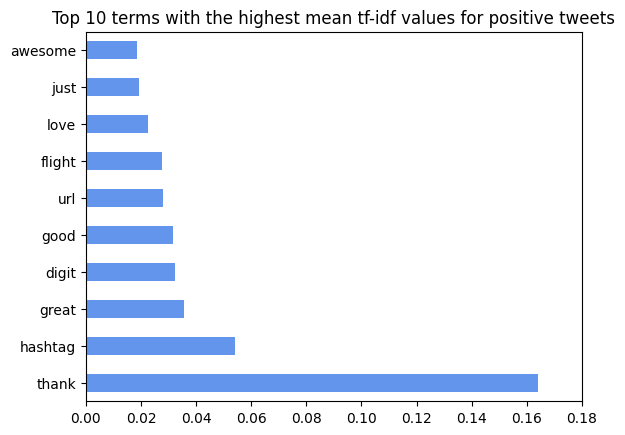

In [125]:
pos.plot(kind='barh', 
         xlim=(0, 0.18),
         color='cornflowerblue',
         title='Top 10 terms with the highest mean tf-idf values for positive tweets');

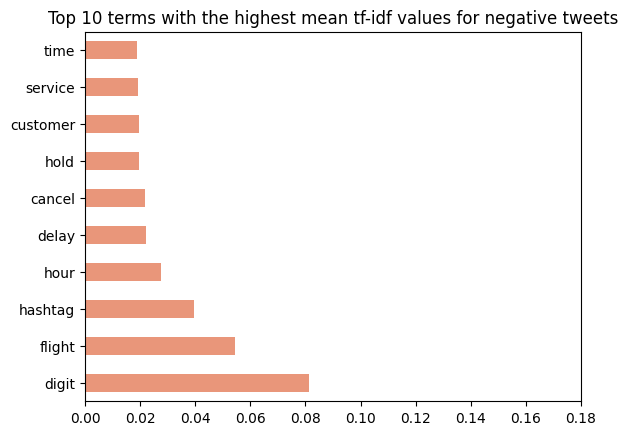

In [126]:
neg.plot(kind='barh', 
         xlim=(0, 0.18),
         color='darksalmon',
         title='Top 10 terms with the highest mean tf-idf values for negative tweets');

🔔 **Question**: How would you interpret these results? Share your thoughts in the chat!

<a id='section5'></a>

## 🎬 **Demo**: Sentiment Classification Using the TF-IDF Representation

Now that we have a tf-idf representation of the text, we are ready to do sentiment analysis!

In this demo, we will use a logistic regression model to perform the classification task. Here we briefly step through how logistic regression works as one of the supervised Machine Learning methods, but feel free to explore our workshop on [Python Machine Learning Fundamentals](https://github.com/dlab-berkeley/Python-Machine-Learning) if you want to learn more about it.

Logistic regression is a linear model, with which we use to predict the label of a tweet, based on a set of features ($x_1, x_2, x_3, ..., x_i$), as shown below:

$$
L = \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_T x_T
$$

The list of features we'll pass to the model is the vocabulary of the DTM. We also feed the model with a portion of the data, known as the training set, along with other model specification, to learn the coeffient ($\beta_1, \beta_2, \beta_3, ..., \beta_i$) of each feature. The coefficients tell us whether a feature contributes positively or negatively to the predicted value. The predicted value corresponds to adding all features (multiplied by their coefficients) up, and the predicted value gets passed to a [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) to be converted into the probability space, which tells us whether the predicted label is positive (when $p>0.5$) or negative (when $p<0.5$). 

The remaining portion of the data, known as the test set, is used to test whether the learned coefficients could be generalized to unseen data. 

Now that we already have the tf-idf dataframe, the feature set is ready. Let's dive into model specification!

In [127]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

We'll use the `train_test_split` function from `sklearn` to separate our data into two sets:

In [128]:
# Train-test split
X = tfidf
y = tweets['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

The `fit_logistic_regression` function is written below to streamline the training process.

In [ ]:
def fit_logistic_regression(X, y):
    '''Fits a logistic regression model to provided data.'''
    model = LogisticRegressionCV(Cs=10,
                                 penalty='l1',
                                 cv=5,
                                 solver='liblinear',
                                 class_weight='balanced',
                                 random_state=42,
                                 refit=True).fit(X, y)
    return model

: 

We'll fit the model and compute the training and test accuracy.

In [ ]:
# Fit the logistic regression model
model = fit_logistic_regression(X_train, y_train)

In [ ]:
# Get the training and test accuracy
print(f"Training accuracy: {model.score(X_train, y_train)}")
print(f"Test accuracy: {model.score(X_test, y_test)}")

Training accuracy: 0.9455601998164951
Test accuracy: 0.894919168591224


The model achieved ~94% accuracy on the training set and ~89% on the test set—that's pretty good! The model generalizes reasonably well to the test data.

Next, let's also take a look at the fitted coefficients to see if what we see makes sense. 

We can access them using `coef_`, and we can match each coefficient to the tokens from the vectorizer:

In [ ]:
# Get coefs of all features
coefs = model.coef_.ravel()

# Get all tokens
tokens = vectorizer.get_feature_names_out()

# Create a token-coef dataframe
importance = pd.DataFrame()
importance['token'] = tokens
importance['coefs'] = coefs

In [ ]:
# Get the top 10 tokens with lowest coefs
neg_coef = importance.sort_values('coefs').head(10)
neg_coef

,token,coefs
2724,rude,-11.138668
2784,screw,-9.962456
2727,ruin,-9.849836
1505,hour,-9.282416
389,break,-7.949487
2280,pay,-7.823908
458,cancel,-7.534084
264,bad,-7.357206
1872,luggage,-7.093317
3034,strand,-7.046890


In [ ]:
# Get the top 10 tokens with highest coefs
pos_coef = importance.sort_values('coefs').tail(10)
pos_coef 

,token,coefs
3165,thankful,8.002975
1091,exceptional,8.136278
1563,impressed,8.501364
648,compliment,8.981360
1373,great,9.080558
3498,wonderful,9.401606
1089,excellent,10.147230
250,awesome,10.315909
1746,kudo,11.623828
3164,thank,16.027534


Let's plot the top 10 tokens with the highest/lowest coefficients. 

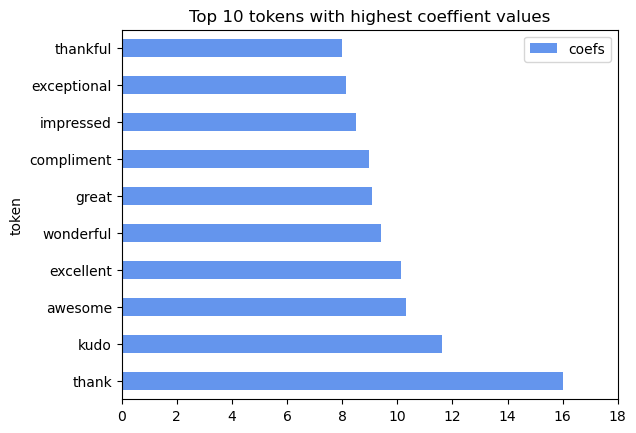

In [ ]:
# Plot the top 10 tokens that have the highest coefs
pos_coef.sort_values('coefs', ascending=False) \
        .plot(kind='barh', 
              xlim=(0, 18),
              x='token',
              color='cornflowerblue',
              title='Top 10 tokens with highest coeffient values');

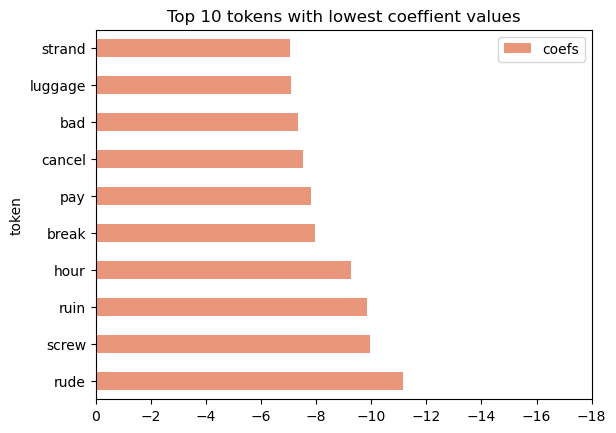

In [ ]:
# Plot the top 10 tokens that have the lowest coefs
neg_coef.plot(kind='barh', 
              xlim=(0, -18),
              x='token',
              color='darksalmon',
              title='Top 10 tokens with lowest coeffient values');

Words like "ruin," "rude," and "hour" are strong indicators of negative sentiment, while "thank," "awesome," and "wonderful" are associated with positive sentiment. 

We will wrap up Part 2 with these plots. These coefficient terms and the words with the highest TF-IDF values provide different perspectives on the sentiment of tweets. If you'd like, take some time to compare the two sets of plots and see which one provides a better account of the sentiments conveyed in tweets.

<div class="alert alert-success">

## ❗ Key Points

* A Bag-of-Words representation is a simple method to transform our text data to numbers. It focuses on word frequency but not word order. 
* A TF-IDF representation is a step further; it also considers if a certain word distinctively appears in one document or occurs uniformally across all documents. 
* With a numerical representation, we can perform a range of text classification task, such as sentiment analysis. 

</div>